# Libraries Importing

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from glob import glob
from tqdm import tqdm

# Image Visualization

In [2]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN/"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST/"

x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 12565/12565 [02:16<00:00, 92.08it/s]


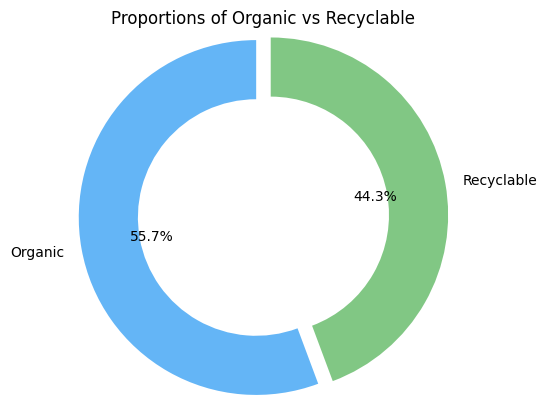

In [3]:
import matplotlib.pyplot as plt

# Data
labels = ['Organic', 'Recyclable']
sizes = data.label.value_counts()

# Modern color palette (vibrant)
colors = ['#64b5f6', '#81c784']  # Blue and Green tones

# Donut chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=[0.05,0.05], 
        colors=colors, radius=1.2, wedgeprops={'width': 0.4})
plt.title('Proportions of Organic vs Recyclable')
plt.show()


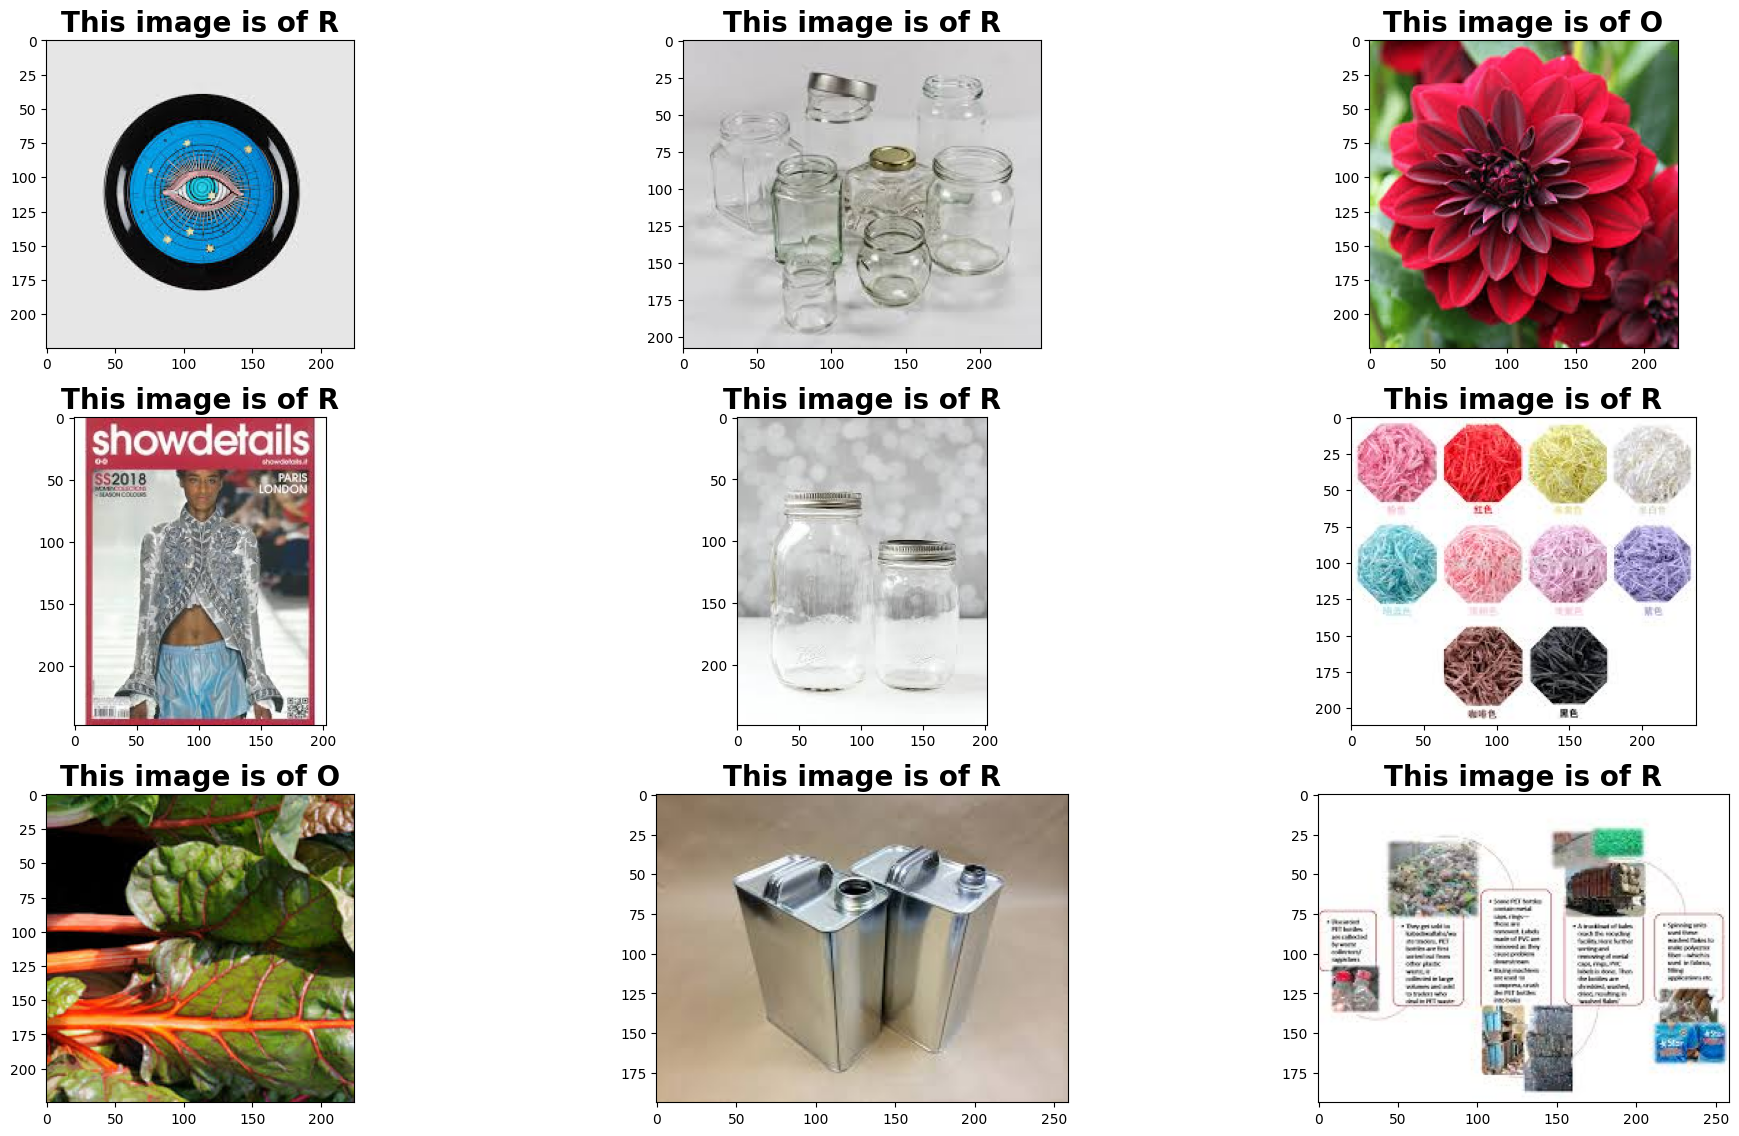

In [4]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

# Data Loading and Preprocessing

In [5]:
train_dir = '/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN'
test_dir = '/kaggle/input/waste-classification-data/dataset/DATASET/TEST'

def load_dataset(path):
    data = load_files(path) 
    files = np.array(data['filenames']) 
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Training set size :  22564
Testing set size :  2513


In [6]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)

**Convert Image Files to NumPy Array that can be used for training machine learning models**

In [7]:
def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) 
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC)
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (18051, 100, 100, 3)
Validation set shape :  (4513, 100, 100, 3)
Test set shape :  (2513, 100, 100, 3)


**Normalization and Reshape Images**

In [8]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_validate = y_validate.reshape(y_validate.shape[0],1)

# Image augmentation

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=0, 
        zoom_range = 0.1, 
        width_shift_range=0.2,
        height_shift_range=0.2, 
        horizontal_flip=False, 
        vertical_flip=False)
datagen.fit(x_train)

# Model Definition

In [10]:
numberOfClass = 2

In [11]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (100,100,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training the Model

In [12]:
history = model.fit(datagen.flow(x_train, y_train, batch_size= 256), epochs = 10, verbose=1,validation_data=(x_valid,y_validate))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.6832 - loss: 0.5978 - val_accuracy: 0.8057 - val_loss: 0.4324
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.8047 - loss: 0.4534 - val_accuracy: 0.8378 - val_loss: 0.3879
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8160 - loss: 0.4208 - val_accuracy: 0.8422 - val_loss: 0.3495
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.8289 - loss: 0.3988 - val_accuracy: 0.8396 - val_loss: 0.3762
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.8387 - loss: 0.3906 - val_accuracy: 0.8648 - val_loss: 0.3182
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.8571 - loss: 0.3536 - val_accuracy: 0.8750 - val_loss: 0.3080
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.8452 - loss: 0.3750 - val_accuracy: 0.8606 - val_loss: 0.3313
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.8612 - loss: 0.3452 - val_accuracy: 0.8569 - val_loss: 0.

# Model Evaluation 

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def accuracy_curves(model):
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validate'], loc='upper left')
    plt.show()


def evaluate_model(model, x_test, y_test):
    # Predict class probabilities for the test set
    y_pred = model.predict(x_test)
    
    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)  # Choose the class with the highest probability

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels))

    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_labels)
    
    # Plotting the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


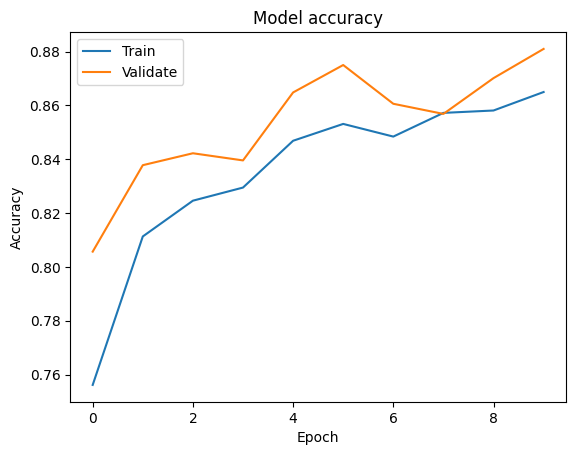

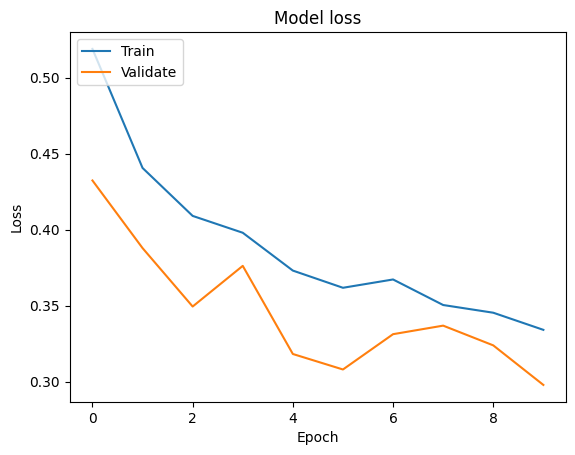

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1401
           1       0.91      0.81      0.86      1112

    accuracy                           0.88      2513
   macro avg       0.89      0.87      0.88      2513
weighted avg       0.88      0.88      0.88      2513

Confusion Matrix:


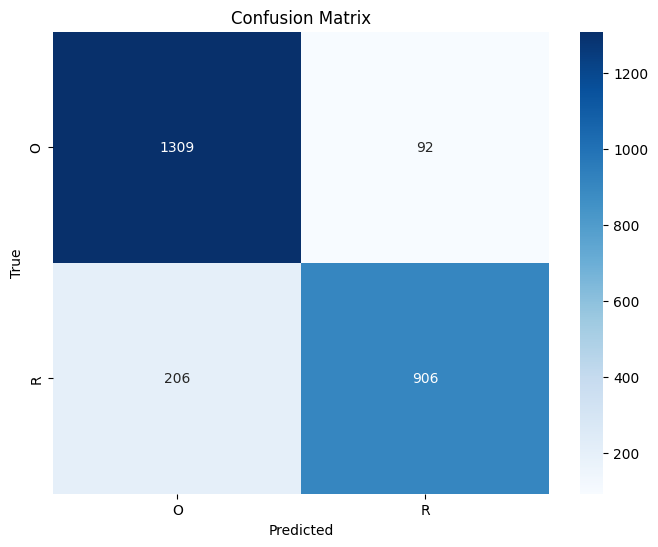

In [14]:
accuracy_curves(history)
evaluate_model(model, x_test, y_test)

Model 

# Enhanced Deep Convolutional Neural Network (CNN) with Batch Normalization, Dropout, and Increased Layers for Image Classification

In [15]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),kernel_initializer='he_normal',activation='relu',input_shape=(100,100,3),name = 'conv0'))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', name = 'conv1'))
model.add(BatchNormalization(name='bn0'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool0'))
model.add(Dropout(0.2,name='dropout0'))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name = 'conv2'))
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', name = 'conv3'))
model.add(BatchNormalization(name='bn1'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool1'))
model.add(Dropout(0.2,name='dropout1'))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',name = 'conv4'))
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name = 'conv5'))
model.add(BatchNormalization(name='bn2'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool2'))
model.add(Dropout(0.3,name='dropout2'))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',name = 'conv6'))
model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name = 'conv7'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool3'))
model.add(Dropout(0.3,name='dropout3'))

model.add(Flatten(name='fc'))
model.add(Dense(512, activation='relu',name = 'Dense0'))
model.add(Dense(256, activation='relu',name = 'Dense1'))
model.add(Dense(128, activation='relu',name = 'Dense2'))
model.add(Dropout(0.3,name='dropout4'))
model.add(Dense(2, activation='softmax',name = 'Dense3'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
checkpoint = ModelCheckpoint(filepath = 'cnn.keras', verbose = 1, save_best_only = True)

In [17]:
earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 15, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

In [18]:
ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)
callbacks = [earlystop, checkpoint, ReduceLR]

history = model.fit(datagen.flow(x_train, y_train, batch_size= 32), epochs = 80, verbose=1,callbacks = callbacks,validation_data=(x_valid,y_validate))

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7525 - loss: 0.5583
Epoch 1: val_loss improved from inf to 1.00638, saving model to cnn.keras
565/565 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.7526 - loss: 0.5581 - val_accuracy: 0.5777 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 2/80
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8161 - loss: 0.4309
Epoch 2: val_loss improved from 1.00638 to 0.36457, saving model to cnn.keras
565/565 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.8161 - loss: 0.4309 - val_accuracy: 0.8252 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 3/80
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8351 - loss: 0.3898
Epoch 3: val_loss did not improve from 0.36457
565/565 ━━━━━━━━━━━━━━━━━━━━ 670s 1s/step - accuracy: 0.8351 - loss: 0.3898 - val_accuracy: 0.8345 - val_loss: 0.3958 - learning_rate: 0.0010
Epoch 4/80
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8505 - loss: 0.3594
Epoch 4: val_loss did not improve from 0.36457

In [19]:
model = load_model('cnn.keras')
model.load_weights('cnn.keras')

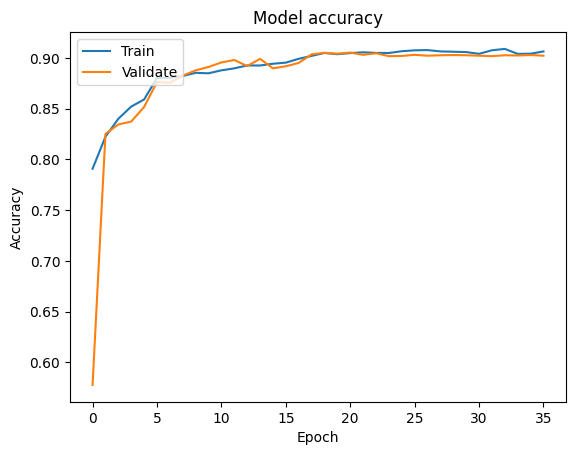

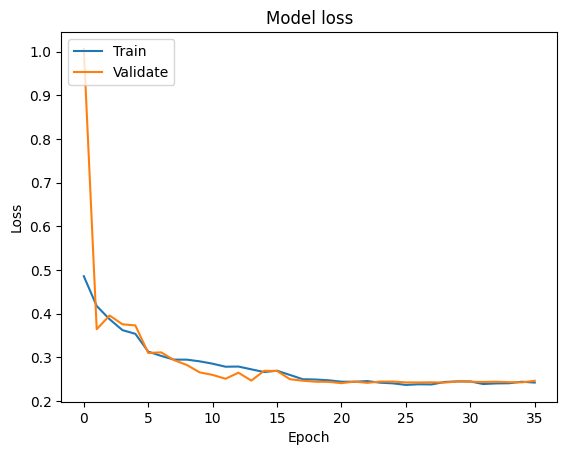

79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1401
           1       0.93      0.88      0.90      1112

    accuracy                           0.92      2513
   macro avg       0.92      0.91      0.92      2513
weighted avg       0.92      0.92      0.92      2513

Confusion Matrix:


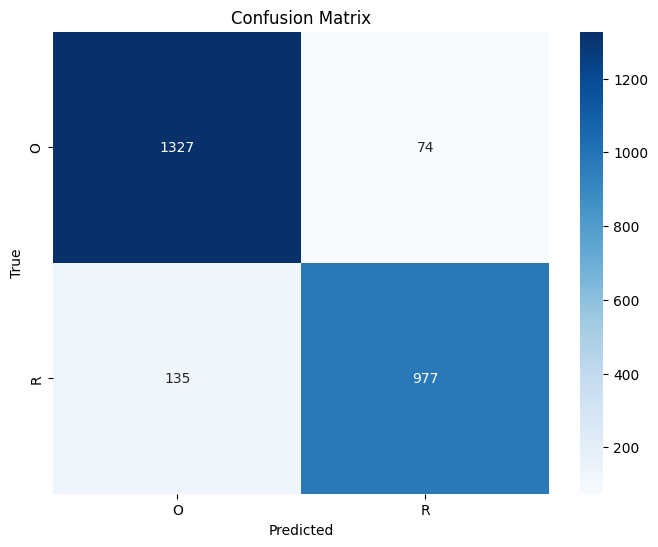

In [20]:
accuracy_curves(history)
evaluate_model(model, x_test, y_test)

# Predictions

# Show random images from the test directory and display predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


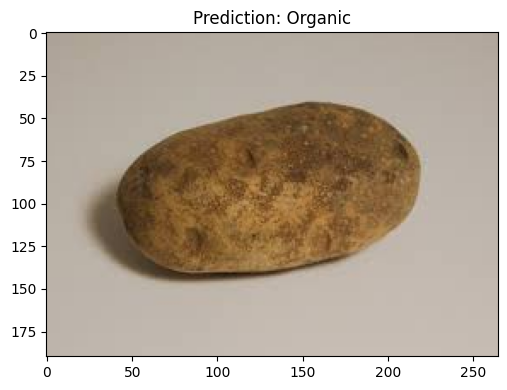

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/O/O_12869.jpg is classified as: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


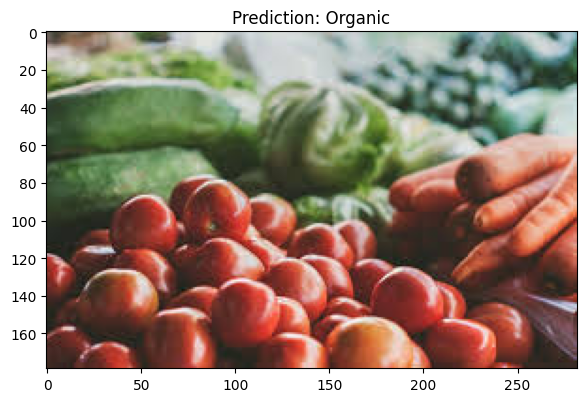

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/O/O_13916.jpg is classified as: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


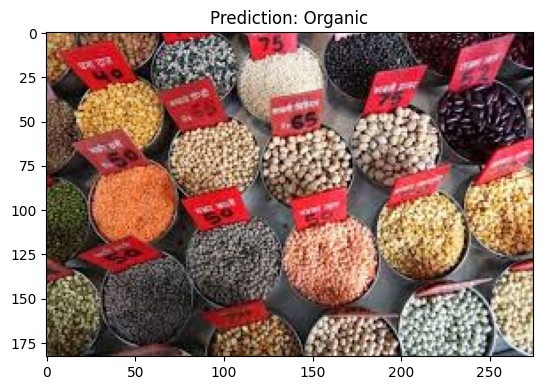

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/O/O_13372.jpg is classified as: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


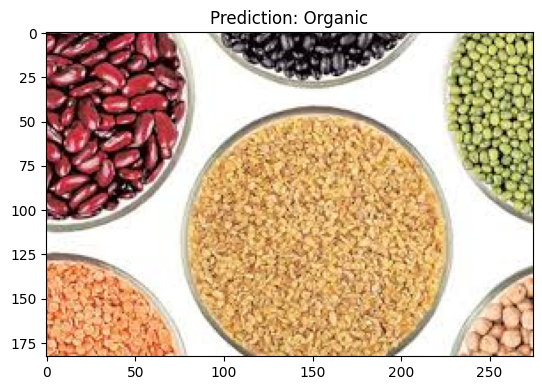

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/O/O_13278.jpg is classified as: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


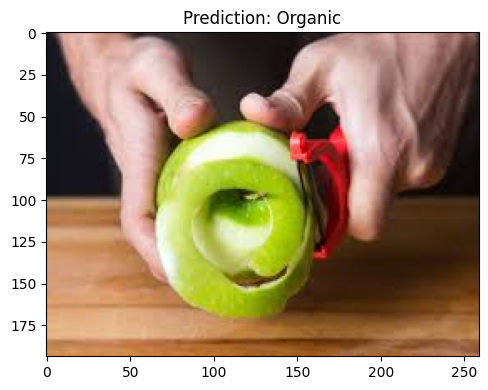

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/O/O_13822.jpg is classified as: O
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


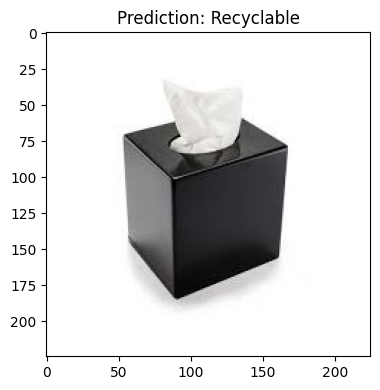

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/R/R_11032.jpg is classified as: R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


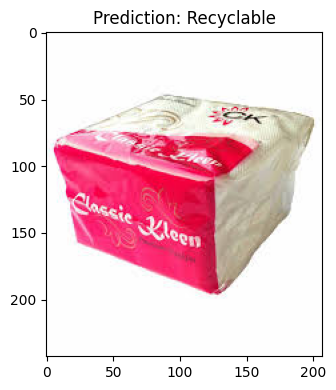

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/R/R_10839.jpg is classified as: R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


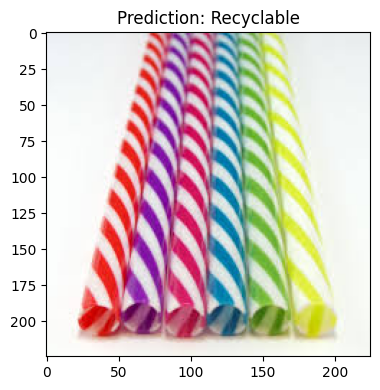

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/R/R_10442.jpg is classified as: R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


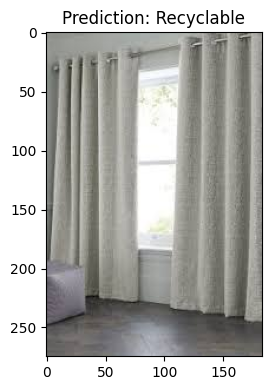

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/R/R_10272.jpg is classified as: R
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


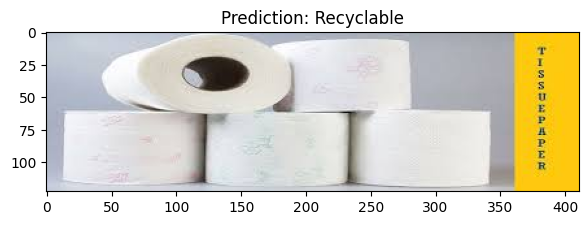

The image /kaggle/input/waste-classification-data/dataset/DATASET/TEST/R/R_10892.jpg is classified as: R


In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
import random

def get_random_images(test_dir, num_images=10):
    """
    Get a random list of image paths from the test directory.
    """
    # Get all image file paths
    image_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    # Select random images
    random_images = random.sample(image_files, num_images)
    
    return random_images


def preprocess_image(img_path, target_size=(100, 100)):
    """
    Preprocesses the input image by resizing, normalizing, and expanding its dimensions.
    """

    img = cv2.imread(img_path)
    
 
    img = cv2.resize(img, target_size)
    

    img = img.astype('float32') / 255.0
    
    
    img = np.expand_dims(img, axis=0)
    
    return img

def predict_func(img_path, model, target_labels):
    """
    Predicts the class of the input image using the trained model.
    """

    img = preprocess_image(img_path)
    

    prediction = model.predict(img)
    
    # Convert the prediction into a class label
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = target_labels[predicted_class]
    

    img_display = cv2.imread(img_path)
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {'Recyclable' if predicted_label == 'R' else 'Organic'}")
    plt.tight_layout()
    plt.show()
    

    return predicted_label


def show_random_images_with_predictions(test_dir, num_images=10):
    random_images = get_random_images(test_dir, num_images=num_images)
    
    for img_path in random_images:
        predicted_label = predict_func(img_path, model, target_labels)
        print(f"The image {img_path} is classified as: {predicted_label}")


show_random_images_with_predictions("/kaggle/input/waste-classification-data/dataset/DATASET/TEST/O", num_images=5)
show_random_images_with_predictions("/kaggle/input/waste-classification-data/dataset/DATASET/TEST/R", num_images=5)



# RealWorld Waste Examples

show_random_images_with_predictions("/kaggle/input/realworldwasteinput/Garbages", num_images=5)